# Topic Visualizations Diagrams

## Python Setup

In [3]:
from pysankey import sankey
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
import seaborn as sns
%matplotlib inline

## Data Read In

In [4]:
one_to_one = pd.read_csv('../output/rcdc_grnt_1_pubs_1_comp.csv')
one_to_many = pd.read_csv('../output/rcdc_grnt_1_pubs_comp.csv')
many_to_many = pd.read_csv('../output/rcdc_grnt_pubs_comp.csv')

In [5]:
funders = set(list(one_to_one['funder_name']))

In [6]:
one_to_one = one_to_one.dropna().reset_index(drop=True)
one_to_many = one_to_many.dropna().reset_index(drop=True)
many_to_many = many_to_many.dropna().reset_index(drop=True)

## Sankey Charts

### Sankey Function

In [7]:
def create_other_category(df):
    tot_pubs = df['nb_pubs'].sum()
    
    df['pub_rcdc_cat'] = np.where(df['nb_pubs']>0.02*tot_pubs, df['pub_rcdc'], "Other")
    df = df.groupby(['funder_name', 'grnt_rcdc', 'pub_rcdc_cat'])
    df = pd.DataFrame({'nb_grnts': df['nb_grnts'].sum()
                       , 'nb_obs': df['nb_obs'].sum()
                       , 'nb_pubs': df['nb_pubs'].sum()}).reset_index()
    
    return df

In [8]:
def create_sankey(df, method, specialty, funder):
    if df.shape[0]==0:
        print("\nNo {} grants with {} as main RCDC code".format(funder, specialty))
    else:
        df['grnts'] = "{} ({} grants)".format(specialty, df['nb_grnts'].sum())
        df['pubs'] = df['pub_rcdc_cat'] + " (" + df['nb_pubs'].astype(str) + " publications)"    
        sankey(left=df['grnts'], right=df['pubs'], rightWeight=df['nb_pubs'], leftWeight=df['nb_grnts']
               , aspect=5, fontsize=5, figureName="../output/sankeys/{} - {} - {}".format(method, specialty, funder))

### Create Graphs

In [9]:
specialty = "Breast Cancer"

#### One to One

In [10]:
for funder in funders:
    df = one_to_one[(one_to_one['funder_name']==funder)&(one_to_one['grnt_rcdc']==specialty)].copy()
    
    df = create_other_category(df)
    
    create_sankey(df, "Method 1", specialty, funder)
    
plt.close('all')


No Wellcome Trust grants with Breast Cancer as main RCDC code

No French Cancer Funders - ORCID Confirmed grants with Breast Cancer as main RCDC code


#### One to Many

In [11]:
for funder in funders:
    df = one_to_many[(one_to_many['funder_name']==funder)&(one_to_many['grnt_rcdc']==specialty)].copy()
    
    df = create_other_category(df)
    
    create_sankey(df, "Method 2", specialty, funder)
    
plt.close('all')


No Wellcome Trust grants with Breast Cancer as main RCDC code

No French Cancer Funders - ORCID Confirmed grants with Breast Cancer as main RCDC code


#### Many to Many

In [12]:
for funder in funders:
    df = many_to_many[(many_to_many['funder_name']==funder)&(many_to_many['grnt_rcdc']==specialty)].copy()
    
    df = create_other_category(df)
    
    create_sankey(df, "Method 3", specialty, funder)
    
plt.close('all')

## Stacked Barcharts

### Functions

In [21]:
def gen_plt_df(grant_df, specialty, thrs_other):
    
    df = grant_df[grant_df['grnt_rcdc']==specialty].copy()
    df = pd.merge(df, df.groupby(['funder_name'])['nb_pubs'].sum().reset_index()
                  , on='funder_name', suffixes=('', '_tot'))
    df = pd.merge(df, df.groupby(['funder_name'])['nb_grnts'].sum().reset_index()
                  , on='funder_name', suffixes=('', '_tot'))
    df['funder_name'] = (df['funder_name'] + " (" 
                         + df['nb_grnts_tot'].astype(str) + " grants, " 
                         + df['nb_pubs_tot'].astype(str) + " pubs)")
    df['pct_pubs'] = df['nb_pubs']/df['nb_pubs_tot']
    df['pub_rcdc_cat'] = np.where(df['pct_pubs']>thrs_other, df['pub_rcdc'], "ZZZOther")
    df = df.groupby(['funder_name', 'grnt_rcdc', 'pub_rcdc_cat', 'nb_pubs_tot'])['nb_pubs'].sum().reset_index()
    df['pct_pubs'] = -df['nb_pubs']/df['nb_pubs_tot']
    
    # Pivot    
    plt_df = df.pivot(index='funder_name', columns='pub_rcdc_cat', values='pct_pubs')
    plt_df.columns = [col.replace('ZZZOther', 'Other') for col in plt_df.columns]

    return plt_df

In [22]:
def stacked_barchart_plot(plt_df, specialty):
    
    # Rename Indexes to several lines
    plt_df.index = [ind.replace(' ', '\n') for ind in plt_df.index]
    plt_df.index = [ind.replace('Research\nUK', 'Research UK') for ind in plt_df.index]
    plt_df.index = [ind.replace('-\nORCID', '- ORCID') for ind in plt_df.index]
    plt_df.index = [ind.replace('Health\nand', 'Health and') for ind in plt_df.index]
    plt_df.index = [ind.replace('\ngrants', ' grants') for ind in plt_df.index]
    plt_df.index = [ind.replace('\npubs', ' pubs') for ind in plt_df.index]
    
    # Plot:
    sns.set()
    lab_sz = 17
    fig, ax = plt.subplots(figsize=(15, 10))
    plt_df.plot(kind='bar', stacked=True, ax=ax, colormap='Dark2', legend='reverse')
    ax.tick_params(axis='both', which='major', labelsize=lab_sz)
    plt.xticks(rotation=0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.yticks(np.arange(0, -1.1, step=-0.1), ('100%','90%','80%','70%','60%','50%','40%','30%','20%','10%','0%'))
    plt.ylim(-1, 0)
    plt.ylabel("Share of Publications by Funded Researchers", fontsize=lab_sz)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': lab_sz})
    plt.title("Publication Topics subsequent to {} Grants\n".format(specialty), fontsize=lab_sz*1.5)
    plt.savefig('../output/barcharts/{}.png'.format(specialty), bbox_inches='tight')

### Create Graphs

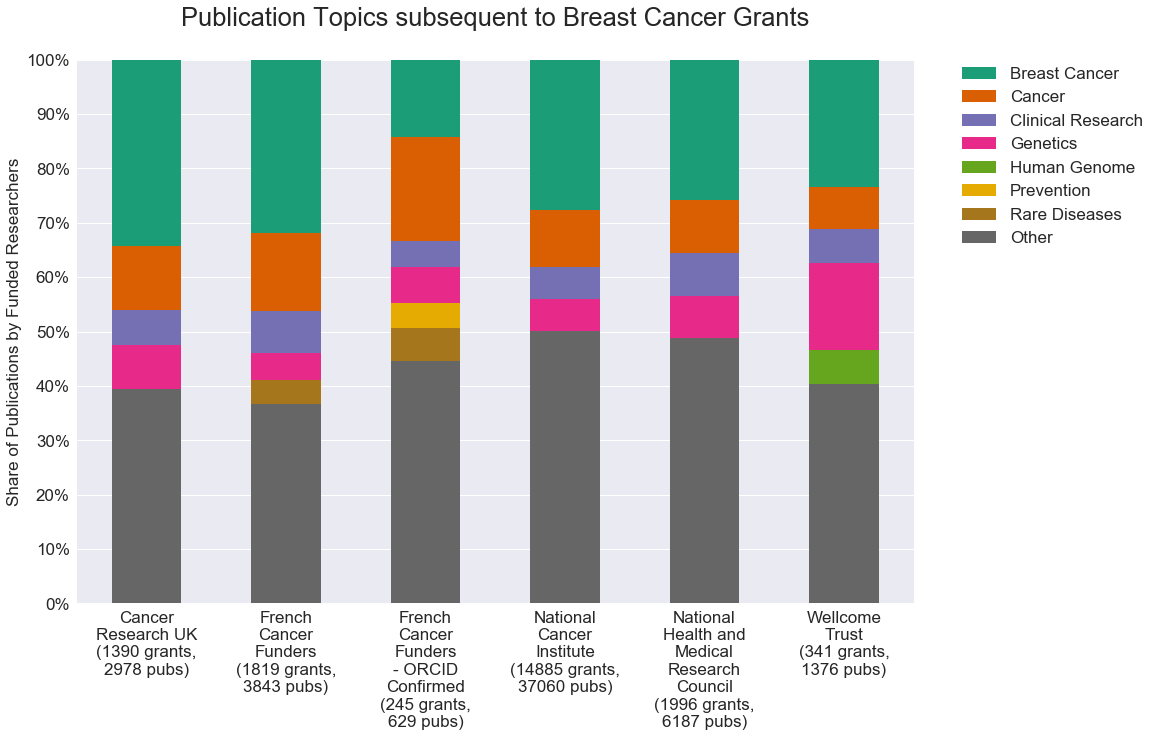

In [25]:
specialty = "Breast Cancer"
thrs_other = 0.04
plt_df = gen_plt_df(grant_df=many_to_many, specialty=specialty, thrs_other=thrs_other)
stacked_barchart_plot(plt_df=plt_df, specialty=specialty)

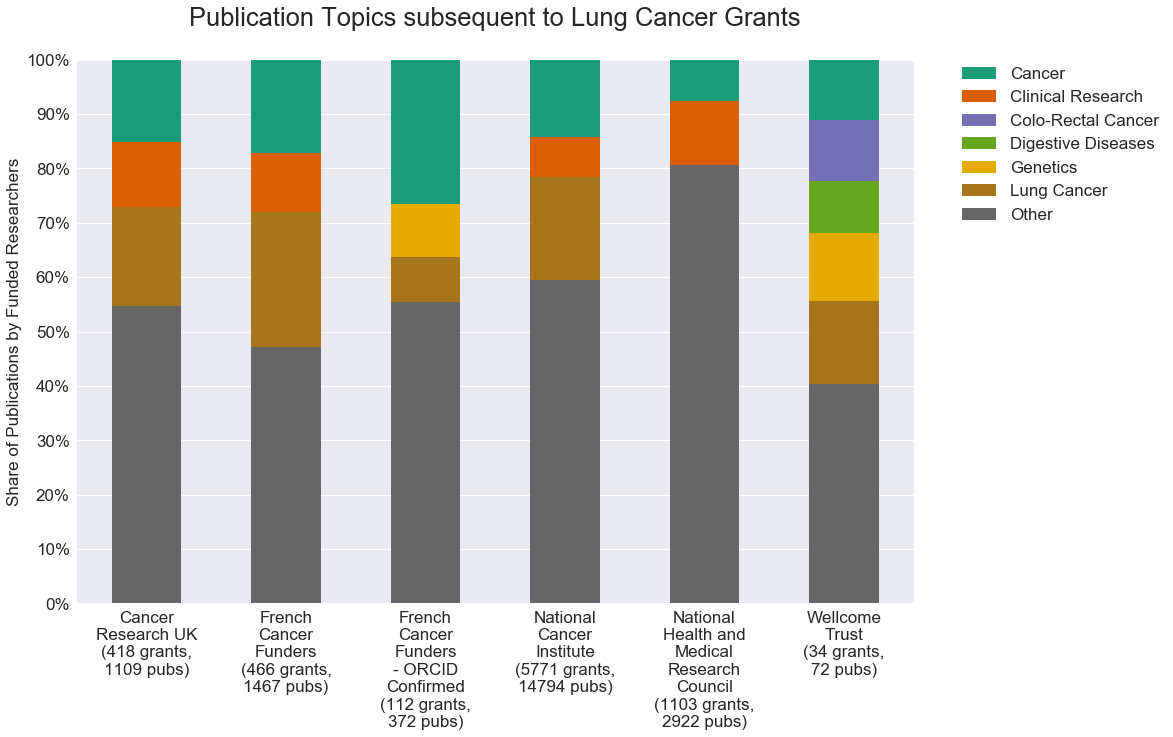

In [26]:
specialty = "Lung Cancer"
thrs_other = 0.07
plt_df = gen_plt_df(grant_df=many_to_many, specialty=specialty, thrs_other=thrs_other)
stacked_barchart_plot(plt_df=plt_df, specialty=specialty)

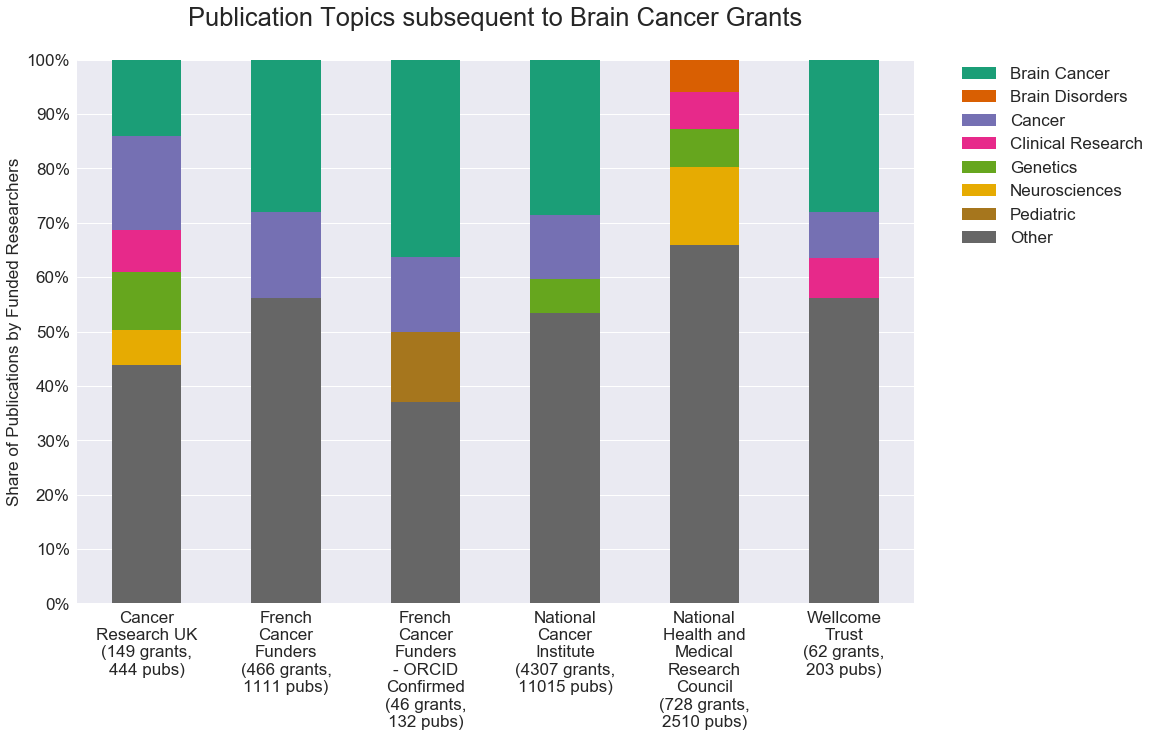

In [27]:
specialty = "Brain Cancer"
thrs_other = 0.0586
plt_df = gen_plt_df(grant_df=many_to_many, specialty=specialty, thrs_other=thrs_other)
stacked_barchart_plot(plt_df=plt_df, specialty=specialty)

## Sandbox